# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

Extractive distillation of MethylCyloHexane/Toluene using Phenol adapted from [Tiverios and Van Brunt in Ind.Eng.Chem.Res. (2000) 39, pp. 1614-1623](http://pubs.acs.org/doi/pdf/10.1021/ie990654k)

[Link to flowsheet on ChemSep homepage](http://www.chemsep.org/downloads/data/CScasebook_MCHT.png)

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")
clr.AddReference(r"..\bin\MiniSim.FlowsheetDrawing")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes
from  MiniSim.Core.Flowsheeting.Documentation import SpreadsheetElement
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem
from  MiniSim.FlowsheetDrawing import FlowsheetDrawer, DrawingOptions

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

In [5]:
def calc(flowsheet, relax, maxIter):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    presolver.Solve(flowsheet)
    print (logger.Flush())
    
def decomp(flowsheet):
    solver= num.DecompositionSolver(logger)
    solver.Solve(flowsheet)
    print (logger.Flush())
    
def thermoAnalysis(psys):
    numComps=len(sys.Components)
    names=sys.GetComponentIds()

    numSteps=20    
    mixture= MaterialStream("Mix", sys)
    mixture.Specify("VF",0.0)
    mixture.Specify("P",psys, METRIC.mbar)
    for c in names:
        mixture.Specify("n["+c+"]",1.0)
    mixture.InitializeFromMolarFlows()
    mixture.FlashPZ()

    test= Flowsheet("test")
    test.AddMaterialStream(mixture)

    solver= num.DecompositionSolver(logger)
    result=solver.Solve(test)

    fig,axs=plt.subplots(numComps,numComps,figsize=(8,8))
    for i in range(numComps):
        for j in range(numComps):       
            if j!=i:
                xvec=[]
                yvec=[]
                for c in range(numSteps):
                    for k in range(numComps):                    
                        mixture.Specify("n["+names[k]+"]",0.0)
                    mixture.Specify("n["+names[i]+"]",c/(numSteps-1))
                    mixture.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
                    mixture.InitializeFromMolarFlows()
                    mixture.FlashPZ()
                    solver.Solve(test)                               
                    xvec.append(mixture.GetVariable('xL['+names[j]+']').Val())               
                    yvec.append(mixture.GetVariable('xV['+names[j]+']').Val())               
                axs[i,j].plot(xvec, yvec)
                axs[i,j].plot(xvec, xvec)              
                axs[i,j].set_title(names[j] +' in '+names[i])
                axs[i,j].set_xlabel('$x_{'+names[j]+'}$')       
                axs[i,j].set_ylabel('$y_{'+names[j]+'}$')
                axs[i, j].set_aspect('equal', 'box')
            else:
                axs[i, j].axis('off')        

    plt.tight_layout()
    logger.Flush()
    plt.suptitle('(x,y)-Diagram at '+str(round(psys,2))+' mbar', y=1.05);    

# Set up Thermodynamics
<div style="width:100%;height:6px;background-color:Black;"></div>

In [6]:
sys= ThermodynamicSystem("Test2","NRTL", "default")

sys.AddComponent(Database.FindComponent("Methylcyclohexane").RenameID("MCH"))
sys.AddComponent(Database.FindComponent("Toluene").RenameID("TOLUOL"))
sys.AddComponent(Database.FindComponent("Phenol").RenameID("PHENOL"))
Database.FillBIPs(sys)
NRTL = sys.GetBinaryParameters("NRTL")
NRTL.SetParam("B",sys.Components[0], sys.Components[1],-43.2404 )
NRTL.SetParam("B",sys.Components[1], sys.Components[0],134.062 )
NRTL.SetParamSymmetric("C",sys.Components[0], sys.Components[1],0.3 )

kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.MW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)

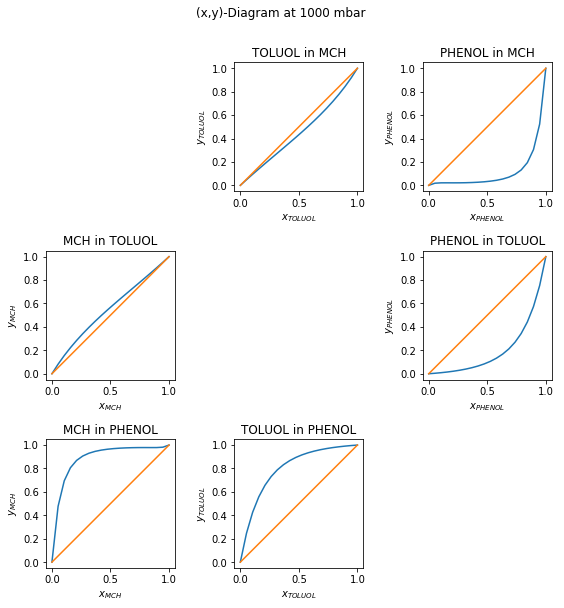

In [7]:
thermoAnalysis(1000)

# Azeotropic column
<div style="width:100%;height:6px;background-color:Black;"></div>

In [8]:
Feed = (MaterialStream("Feed", sys)
        .Specify("T",25, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n[MCH]",90, kmolh)
        .Specify("n[TOLUOL]", 90, kmolh)
        .Specify("n[PHENOL]", 0, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

Recycle = (MaterialStream("Recycle", sys)
        .Specify("T",151, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n[MCH]",0, kmolh)
        .Specify("n[TOLUOL]", 0.1, kmolh)
        .Specify("n[PHENOL]", 250, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

S01 = MaterialStream("S01", sys)
S02 = MaterialStream("S02", sys)
S03 = (MaterialStream("S03", sys)
        .Init("T", 101, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",719, kmolh)
        .Init("n[TOLUOL]", 6, kmolh)
        .Init("n[PHENOL]", 0.1, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

S04 = MaterialStream("S04", sys)
S05 = (MaterialStream("S05", sys)
        .Init("T", 150, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",0, kmolh)
        .Init("n[TOLUOL]", 450, kmolh)
        .Init("n[PHENOL]", 179, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

MCH = MaterialStream("MCH", sys)
B1 = MaterialStream("B1", sys)

C1 = (EquilibriumStageSection("C1",sys,39)
        .Connect("VIn", S05)
        .Connect("LIn", S03)
        .Connect("VOut", S01)
        .Connect("LOut", S04)
        .ConnectFeed(Feed,25)
        .ConnectFeed(Recycle,10)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(4.7,0.7,logger))

REB1 = (Flash("REB1",sys)
        .Connect("In", S04)
        .Connect("Vap", S05)
        .Connect("Liq", B1)
        .Specify("P", 1, METRIC.bar)
        .Specify("VF",0.65)
        .Initialize())

COND1 = (Heater("COND1",sys)
        .Connect("In", S01)
        .Connect("Out", S02)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0)\
        .Initialize())

RefluxRatio1=4.7
REFSPL1 = (Splitter("REFSPL1",sys)\
        .Connect("In", S02)\
        .Connect("Out1", MCH)\
        .Connect("Out2", S03)\
        .Specify("DP",0, METRIC.bar)\
        .Specify("K",1-RefluxRatio1/(1.0+RefluxRatio1))\
        .Initialize())

flowsheet= (Flowsheet("Flow")
        .AddMaterialStreams(Feed, Recycle, S01,S02,S03,B1,S04,S05, MCH)
        .AddUnits(C1, REB1, COND1, REFSPL1))

In [9]:
decomp(flowsheet)
decomp(flowsheet)

Decomposition Result: V=117, E=117, Blocks=1, Singletons=0
Block Statistics:
   # Var # Blocks % Blocks
     117        1 100,00 %
Problem Column Init was successfully solved (0,04 seconds)
Decomposition Result: V=802, E=802, Blocks=165, Singletons=151
Block Statistics:
   # Var # Blocks % Blocks
       1      151  91,52 %
       4        6   3,64 %
       7        4   2,42 %
       8        3   1,82 %
     575        1   0,61 %
Solving problem Subproblem 76 (Size: 575) failed!
The 10 most problematic constraints are:
TraySection          C1                                  -0,11003937 ( EQ000385 >> 0 := (V[16] * HV[16] + L[14] * HL[14] + F[15] * HF[15] + Q[15]) / 1000 - ((1 + RV[15]) * V[15] * HV[15] + (1 + RL[15]) * L[15] * HL[15]) / 1000 = -0,110039368611069 )
TraySection          C1                                  -0,10935191 ( EQ000399 >> 0 := (V[17] * HV[17] + L[15] * HL[15] + F[16] * HF[16] + Q[16]) / 1000 - ((1 + RV[16]) * V[16] * HV[16] + (1 + RL[16]) * L[16] * HL[16]) / 1000

In [10]:
reporter.Report(flowsheet,5,False)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              25.0000     151.0000     101.6468     101.4339     101.4339
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -36880.0451  -32748.4198   11111.8635  -20705.0401  -20705.0401
Phase                                      Liquid       Liquid  LiquidVapor  BubblePoint       Liquid

Total Molar Flow          kmol/h         180.0000     250.1000     690.8486     690.8486     569.6471
                      MCH kmol/h          90.0000       0.0000     512.9497     512.9497     422.9586
                   TOLUOL kmol/h          90.0000       0.1000     177.8988     177.8988     146.

# Stripping column
<div style="width:100%;height:6px;background-color:Black;"></div>

In [11]:
S06 = MaterialStream("S06", sys)
S07 = MaterialStream("S07", sys)
S08 = (MaterialStream("S08", sys)
        .Init("T", 110, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",1, kmolh)
        .Init("n[TOLUOL]", 400, kmolh)
        .Init("n[PHENOL]", 10, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

S09 = MaterialStream("S09", sys)

S10 = (MaterialStream("S10", sys)
        .Init("T", 180, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",1, kmolh)
        .Init("n[TOLUOL]", 1, kmolh)
        .Init("n[PHENOL]", 300, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

Toluol = MaterialStream("Toluol", sys)
B2 = MaterialStream("B2", sys)

C2 = (EquilibriumStageSection("C2",sys,19)
        .Connect("VIn", S10)
        .Connect("LIn", S08)
        .Connect("VOut", S06)
        .Connect("LOut", S09)
        .ConnectFeed(B1,12)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(2.9,0.2,logger))

REB2 = (Flash("REB2",sys)
        .Connect("In", S09)
        .Connect("Vap", S10)
        .Connect("Liq", B2)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0.4)
        .Initialize())

COND2 = (Heater("COND2",sys)
    .Connect("In", S06)
    .Connect("Out", S07)
    .Specify("P",1, METRIC.bar)
    .Specify("VF",0)
    .Initialize())

RefluxRatio2=2.9
REFSPL2 = (Splitter("REFSPL2",sys)
    .Connect("In", S07)
    .Connect("Out1", Toluol)
    .Connect("Out2", S08)
    .Specify("DP",0, METRIC.bar)
    .Specify("K",0.47)
    .Initialize())

C2.Initialize(1.9,0.2,logger)
REB2.Solve()
COND2.Solve()
REFSPL2.Solve()
logger.Flush()

flowsheet.AddMaterialStreams(S06,S07,S08,B2,S09,S10,Toluol).AddUnits(C2, REB2, COND2, REFSPL2);

In [12]:
decomp(flowsheet)

Decomposition Result: V=1279, E=1279, Blocks=283, Singletons=259
Block Statistics:
   # Var # Blocks % Blocks
       1      259  91,52 %
       4       10   3,53 %
       7        6   2,12 %
       8        6   2,12 %
     315        1   0,35 %
     575        1   0,35 %
Problem NLAES was successfully solved (0,47 seconds)



# Reach Design Specifications: Purities
<div style="width:100%;height:6px;background-color:Black;"></div>

In [13]:
REB1.Unspecify("VF")
MCH.GetVariable("x[MCH]").Fix(0.99)

decomp(flowsheet)

Decomposition Result: V=1279, E=1279, Blocks=279, Singletons=256
Block Statistics:
   # Var # Blocks % Blocks
       1      256  91,76 %
       4        9   3,23 %
       7        6   2,15 %
       8        6   2,15 %
     315        1   0,36 %
     582        1   0,36 %
Problem NLAES was successfully solved (0,69 seconds)



In [14]:
REB2.Unspecify("VF")
Toluol.GetVariable("x[TOLUOL]").Fix(0.99)

decomp(flowsheet)

Decomposition Result: V=1279, E=1279, Blocks=275, Singletons=253
Block Statistics:
   # Var # Blocks % Blocks
       1      253  92,00 %
       4        8   2,91 %
       7        6   2,18 %
       8        6   2,18 %
     322        1   0,36 %
     582        1   0,36 %
Problem NLAES was successfully solved (0,29 seconds)



# Close Recycle loop
<div style="width:100%;height:6px;background-color:Black;"></div>

In [15]:
Recycle.Unfix()
Makeup = (MaterialStream("Makeup", sys)
        .Specify("T",104, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n[MCH]",0, kmolh)
        .Specify("n[TOLUOL]", 0, kmolh)
        .Init("n[PHENOL]", 0.03, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

MIX01 = (Mixer("MIX01",sys)
    .Connect("In", B2)
    .Connect("In", Makeup)
    .Connect("Out", Recycle)
    .Specify("DP",0, METRIC.bar)
    .Initialize())

flowsheet.AddMaterialStream(Makeup).AddUnit(MIX01)
Recycle.GetVariable("n").Fix(251/3.6)

In [16]:
calc(flowsheet,1.00,20)
decomp(flowsheet)

Iter Step Length     Infeasibility   Damping Notes
0    0               146,294         1       
1    482751          142,353         0,026816984082171 
2    468560          55,0924         1       
3    535,065         0,228559        1       
4    6,03351E+06     1               0,00946077585342315 
5    51084,4         0,405438        0,998062608603029 
6    3798,61         0,00771505      1       
7    1866,69         0,00543514      1       
8    978,821         0,0018486       1       
9    437,304         0,0012076       1       
10   4,80447E+06     1,23877         0,0104949554286118 
11   50699,8         1,23262         1       
12   119,137         0,000981655     1       
13   2,93977E+08     245105          0,001   
14   5,80039E+07     244860          0,001   
15   1,68703E+07     41905,3         1       
16   8,55631E+07     25163,8         0,178044445756221 
17   754229          7582,4          1       
18   2,97523E+06     2016,55         0,909368140173189 
19   2,21122

# Print Results
<div style="width:100%;height:6px;background-color:Black;"></div>

In [17]:
reporter.Report(flowsheet,5,False)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              25.0000     180.4322     100.4252     100.4183     100.4183
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -36880.0451  -25842.8226   11590.0218  -19609.6324  -19609.6324
Phase                                      Liquid       Liquid        Vapor  BubblePoint  LiquidVapor

Total Molar Flow          kmol/h         180.0000     251.0000     517.6848     517.6848     426.8629
                      MCH kmol/h          90.0000       0.0000     512.5079     512.5079     422.5943
                   TOLUOL kmol/h          90.0000       0.2212       4.8262       4.8262       3.

# Column Profiles
## Azeotropic Column

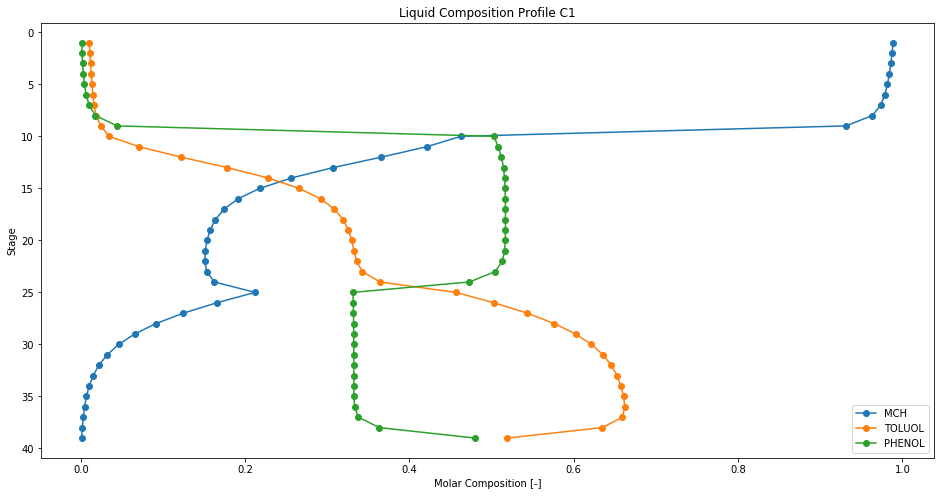

In [18]:
x={}
x["MCH"]=C1.GetProfile("x","MCH")
x["TOLUOL"]=C1.GetProfile("x","TOLUOL")
x["PHENOL"]=C1.GetProfile("x","PHENOL")

stages= range(1, C1.NumberOfTrays+1)
df_comp= pd.DataFrame(zip(x["MCH"],x["TOLUOL"],x["PHENOL"] ), 
                      index=stages, 
                      columns=sys.GetComponentIds())

plt.plot( df_comp["MCH"], stages, linestyle='-', marker='o')
plt.plot( df_comp["TOLUOL"], stages, linestyle='-', marker='o')
plt.plot( df_comp["PHENOL"], stages, linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.legend(sys.GetComponentIds())
plt.xlabel("Molar Composition [-]")
plt.ylabel("Stage")
plt.title("Liquid Composition Profile C1");

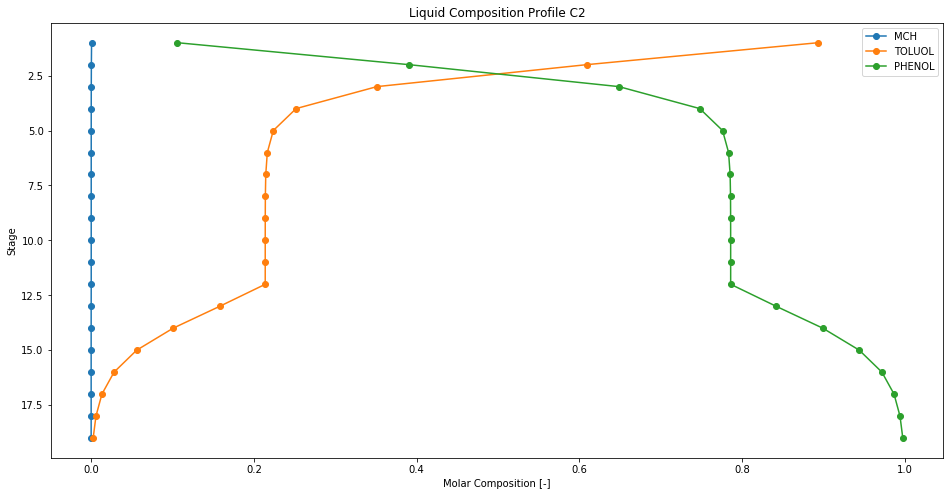

In [19]:
x={}
x["MCH"]=C2.GetProfile("x","MCH")
x["TOLUOL"]=C2.GetProfile("x","TOLUOL")
x["PHENOL"]=C2.GetProfile("x","PHENOL")

stages= range(1, C2.NumberOfTrays+1)
df_comp= pd.DataFrame(zip(x["MCH"],x["TOLUOL"],x["PHENOL"] ), 
                      index=stages, 
                      columns=sys.GetComponentIds())

plt.plot( df_comp["MCH"], stages, linestyle='-', marker='o')
plt.plot( df_comp["TOLUOL"], stages, linestyle='-', marker='o')
plt.plot( df_comp["PHENOL"], stages, linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.legend(sys.GetComponentIds())
plt.xlabel("Molar Composition [-]")
plt.ylabel("Stage")
plt.title("Liquid Composition Profile C2");

# Block Flow Diagram

In [20]:
from IPython.display import Image as render

def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 

In [21]:
C1.SetIcon(IconTypes.ColumnSection, 300,260).SetColors("Green","White")
REB1.SetIcon(IconTypes.TwoPhaseFlash, 380,500)
COND1.SetIcon(IconTypes.Heater, 380,120)
REFSPL1.SetIcon(IconTypes.Splitter, 510,190)
C2.SetIcon(IconTypes.ColumnSection, 790,270).SetColors("OrangeRed","White")
REB2.SetIcon(IconTypes.TwoPhaseFlash, 890,540)
COND2.SetIcon(IconTypes.Heater, 890,120)
REFSPL2.SetIcon(IconTypes.Splitter, 1070,190)
MIX01.SetIcon(IconTypes.Mixer, 170,440)
Feed.SetIcon(IconTypes.Stream, 10,340)
MCH.SetIcon(IconTypes.Stream, 620,120)
Toluol.SetIcon(IconTypes.Stream, 1160,120)
Makeup.SetIcon(IconTypes.Stream, 10,440)

sheet1=(SpreadsheetElement("Results")
    .SetIcon(IconTypes.Spreadsheet, 980,360)
    .SetSize(400,400)
    .AddVariable(REB1.GetVariable("Q"))
    .AddVariable(COND1.GetVariable("Q"))
    .AddVariable(REB2.GetVariable("Q"))
    .AddVariable(COND2.GetVariable("Q"))
    .AddVariable(REFSPL1.GetVariable("K"))
    .AddVariable(REFSPL2.GetVariable("K"))
    .AddVariable(REB1.GetVariable("VF"))
    .AddVariable(REB2.GetVariable("VF"))
       )

flowsheet.AddDocumentation(sheet1)

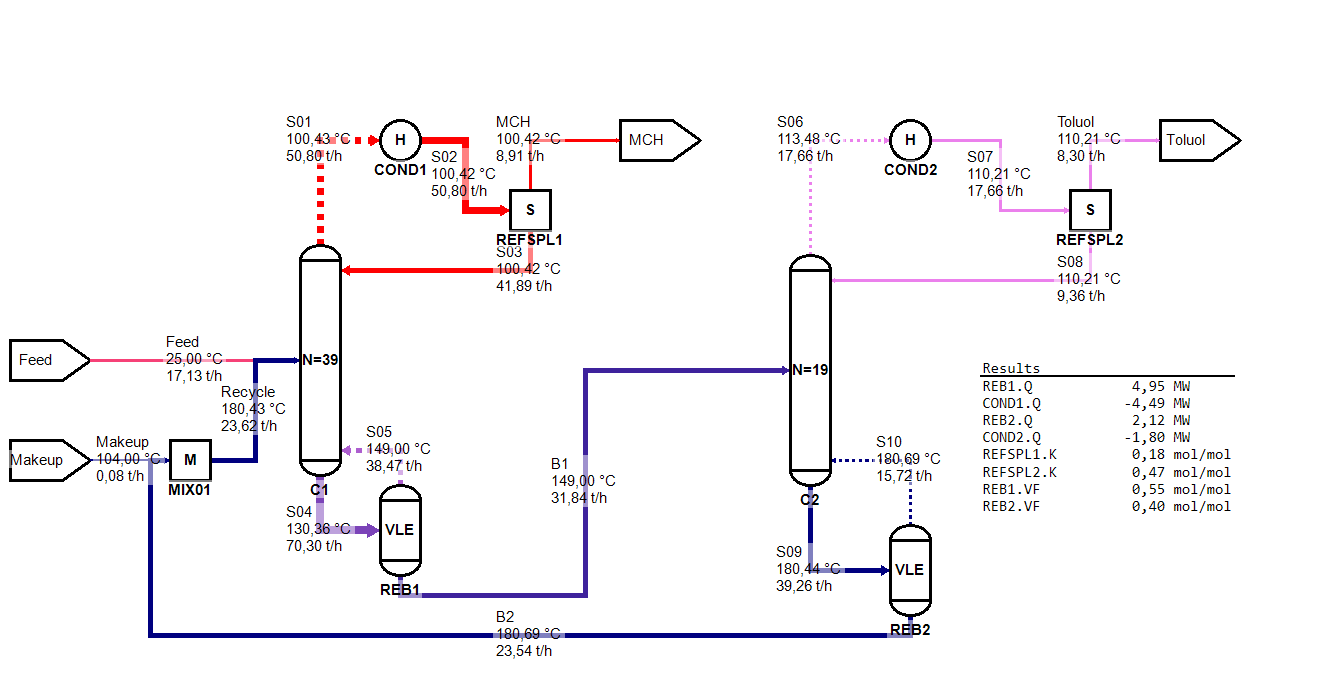

In [22]:
options=DrawingOptions()
options.ShowStreamWidth=True
options.ShowPressure=False
options.ShowTemperature=True
options.ShowStreamColors=True
options.ColorMap["MCH"]="Red"
options.ColorMap["TOLUOL"]="Violet"
options.ColorMap["PHENOL"]="Navy"
render(convertFlowsheet(flowsheet,options))